<a href="https://colab.research.google.com/github/amirmafzali/Neural_network-and-deep-learning_course/blob/main/Transformer%20fine%20tune%20CIFAR-10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **BEiT** transformer model for **CIFAR**-10 classification 

In [25]:
!pip install datasets transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
from datasets import load_dataset
import random
from PIL import ImageDraw, ImageFont, Image
from transformers import BeitFeatureExtractor
from torch.utils.data import DataLoader
import torch
from transformers import BeitForImageClassification
from transformers import TrainingArguments, Trainer
from datasets import load_metric
import numpy as np
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [27]:
train_ds, test_ds = load_dataset('cifar10', split=['train','test'])
splits = train_ds.train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']

  0%|          | 0/2 [00:00<?, ?it/s]

In [28]:
train_ds

Dataset({
    features: ['img', 'label'],
    num_rows: 45000
})

In [29]:
test_ds

Dataset({
    features: ['img', 'label'],
    num_rows: 10000
})

In [30]:
val_ds

Dataset({
    features: ['img', 'label'],
    num_rows: 5000
})

In [31]:
train_ds.features

{'img': Image(decode=True, id=None),
 'label': ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], id=None)}

In [32]:
id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
id2label

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [33]:
feature_extractor = BeitFeatureExtractor.from_pretrained("microsoft/beit-base-patch16-224")

loading configuration file preprocessor_config.json from cache at /root/.cache/huggingface/hub/models--microsoft--beit-base-patch16-224/snapshots/f73f827d08788b563c0b7a3eb04169a77e79a588/preprocessor_config.json
{param_name} should be a dictionary on of the following set of keys: {VALID_SIZE_DICT_KEYS}, got {size}. Converted to {size_dict}.
{param_name} should be a dictionary on of the following set of keys: {VALID_SIZE_DICT_KEYS}, got {size}. Converted to {size_dict}.
Image processor BeitImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": false,
  "do_normalize": true,
  "do_reduce_labels": false,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "BeitFeatureExtractor",
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "BeitImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [34]:
def transform(example_batch):
    inputs = feature_extractor([x for x in example_batch['img']], return_tensors='pt')
    inputs['label'] = example_batch['label']
    return inputs

train_ds = train_ds.with_transform(transform)
test_ds = test_ds.with_transform(transform)
val_ds = val_ds.with_transform(transform)

In [35]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [36]:
model = BeitForImageClassification.from_pretrained("microsoft/beit-base-patch16-224",
                                                  num_labels=10,
                                                  id2label=id2label,
                                                  label2id=label2id,
                                                  ignore_mismatched_sizes=True)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--microsoft--beit-base-patch16-224/snapshots/f73f827d08788b563c0b7a3eb04169a77e79a588/config.json
Model config BeitConfig {
  "architectures": [
    "BeitForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "auxiliary_channels": 256,
  "auxiliary_concat_input": false,
  "auxiliary_loss_weight": 0.4,
  "auxiliary_num_convs": 1,
  "drop_path_rate": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "airplane",
    "1": "automobile",
    "2": "bird",
    "3": "cat",
    "4": "deer",
    "5": "dog",
    "6": "frog",
    "7": "horse",
    "8": "ship",
    "9": "truck"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "airplane": 0,
    "automobile": 1,
    "bird": 2,
    "cat": 3,
    "deer": 4,
    "dog": 5,
    "frog": 6,
    "horse": 7,
    "ship": 8,
    "truck": 9
  },
  "lay

In [37]:
metric_name = "accuracy"

args = TrainingArguments(
    f"test-cifar-10",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    learning_rate=2e-4,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=2,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [38]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [39]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
)

In [40]:
trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 45000
  Num Epochs = 2
  Instantaneous batch size per device = 10
  Total train batch size (w. parallel, distributed & accumulation) = 10
  Gradient Accumulation steps = 1
  Total optimization steps = 9000
  Number of trainable parameters = 85769674


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Accuracy
1,1.323100,1.300496,0.511800
2,1.013200,1.007672,0.643000


***** Running Evaluation *****
  Num examples = 5000
  Batch size = 4
Saving model checkpoint to test-cifar-10/checkpoint-4500
Configuration saved in test-cifar-10/checkpoint-4500/config.json
Model weights saved in test-cifar-10/checkpoint-4500/pytorch_model.bin
Image processor saved in test-cifar-10/checkpoint-4500/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 5000
  Batch size = 4
Saving model checkpoint to test-cifar-10/checkpoint-9000
Configuration saved in test-cifar-10/checkpoint-9000/config.json
Model weights saved in test-cifar-10/checkpoint-9000/pytorch_model.bin
Image processor saved in test-cifar-10/checkpoint-9000/preprocessor_config.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from test-cifar-10/checkpoint-9000 (score: 0.643).


TrainOutput(global_step=9000, training_loss=1.3640161878797743, metrics={'train_runtime': 4004.4667, 'train_samples_per_second': 22.475, 'train_steps_per_second': 2.247, 'total_flos': 6.97179824345088e+18, 'train_loss': 1.3640161878797743, 'epoch': 2.0})

In [41]:
outputs = trainer.predict(test_ds)

***** Running Prediction *****
  Num examples = 10000
  Batch size = 4


In [46]:
outputs.metrics

{'test_loss': 1.0295029878616333,
 'test_accuracy': 0.6329,
 'test_runtime': 153.0293,
 'test_samples_per_second': 65.347,
 'test_steps_per_second': 16.337}

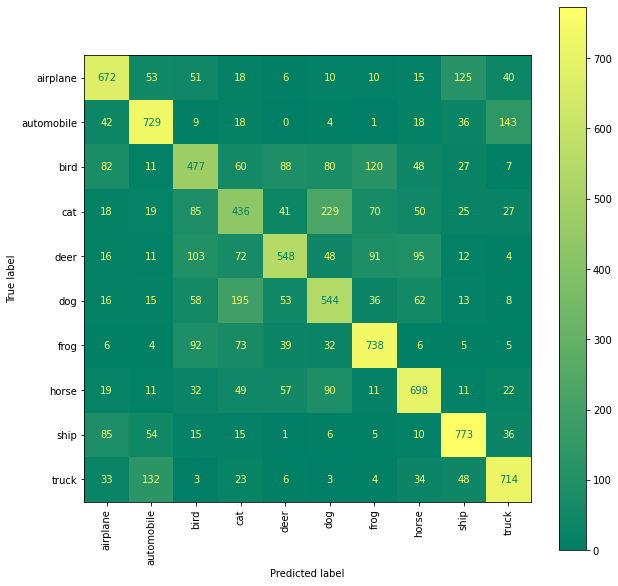

In [43]:
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_ds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax,cmap='summer')